# Text modeling
- Explore and pre-process text
- Train generic embeddings with Google News corpus
- Use Word2Vec to create vectors from project blurb
- Test model somehow

In [4]:
# Import packages

import numpy as np
import pandas as pd
import csv
import numpy as np
import scipy
import six
import smart_open as so

In [6]:
# Read in df
df = pd.read_csv('output/ks_struct_nodata.csv', sep='\t')

In [33]:
df.head()

,table_id,robot_id,run_id,country,state,projecturls,data_id,d_name,d_blurb,d_goal,...,d_launchedat,d_staffpick,d_nobackers,d_spotlight,location_id,loc_name,loc_state,category_id,cat_name,cat_slug
0,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/184955320...,521645557,How to Breathe Underwater/In the Black Box -- ...,A surrealist's guide to navigating the dark de...,1500.0,...,1465488766,False,44,True,2356940.0,Athens,GA,42,Pop,music/pop
1,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/760226815...,504193797,Backpackable one-person high resolution UAV ma...,Continue to develop a user friendly one-person...,10000.0,...,1397105848,False,3,False,2441116.0,Logan,UT,336,Flight,technology/flight
2,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/143006059...,1667139345,LOVE STORY,LOVE STORY IS ABOUT THE REAL LOVE THAT PEOPLE ...,2500.0,...,1376512056,False,5,False,2503713.0,Tallahassee,FL,44,World Music,music/world music
3,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/533614462...,1389221860,Detroit Revue Concert,Together we can bring a star back on the map o...,35500.0,...,1375666413,False,0,False,2391585.0,Detroit,MI,44,World Music,music/world music
4,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/131995875...,1730678034,"Let's Commit (to) a MURDER, SHE WROTE Album of...",Songwriter Joel B. New is creating his first-e...,6500.0,...,1457360083,False,165,True,2459115.0,New York,NY,42,Pop,music/pop


## Clean up data (remove dupes, pre-process main text field)

In [8]:
df_copy = df.copy()

In [31]:
df.shape == df_copy.shape

True

In [32]:
df.shape

(139246, 25)

In [36]:
nodupes = df_copy.drop_duplicates()

In [37]:
nodupes.shape

(123681, 25)

In [70]:
nodupes.head(6)

,table_id,robot_id,run_id,country,state,projecturls,data_id,d_name,d_blurb,d_goal,...,d_launchedat,d_staffpick,d_nobackers,d_spotlight,location_id,loc_name,loc_state,category_id,cat_name,cat_slug
0,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/184955320...,521645557,How to Breathe Underwater/In the Black Box -- ...,A surrealist's guide to navigating the dark de...,1500.0,...,1465488766,False,44,True,2356940.0,Athens,GA,42,Pop,music/pop
1,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/760226815...,504193797,Backpackable one-person high resolution UAV ma...,Continue to develop a user friendly one-person...,10000.0,...,1397105848,False,3,False,2441116.0,Logan,UT,336,Flight,technology/flight
2,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/143006059...,1667139345,LOVE STORY,LOVE STORY IS ABOUT THE REAL LOVE THAT PEOPLE ...,2500.0,...,1376512056,False,5,False,2503713.0,Tallahassee,FL,44,World Music,music/world music
3,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/533614462...,1389221860,Detroit Revue Concert,Together we can bring a star back on the map o...,35500.0,...,1375666413,False,0,False,2391585.0,Detroit,MI,44,World Music,music/world music
4,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/131995875...,1730678034,"Let's Commit (to) a MURDER, SHE WROTE Album of...",Songwriter Joel B. New is creating his first-e...,6500.0,...,1457360083,False,165,True,2459115.0,New York,NY,42,Pop,music/pop
5,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/904448565...,25603479,Donald Trump Kiss Leggings - Inspired by H.P. ...,"Leggings featuring the head, lips, and skin of...",230.0,...,1441342368,False,15,True,2487956.0,San Francisco,CA,263,Apparel,fashion/apparel


In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
import re

In [64]:
for i in nodupes['d_blurb']:
    if type(i) != str:
        i.astype(str)

nan


In [77]:
nodupes['d_blurb'] = nodupes['d_blurb'].astype(str)

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
type(nodupes['d_blurb'])

pandas.core.series.Series

In [50]:
# Define a function that cleans strings: lowercase, remove select punctuation, tokenize
def clean_text(my_str):
    str_low = my_str.lower()
    remove = string.punctuation
    remove = remove.replace(".", " ").replace(",", " ").replace("'", " ")
    pattern = r"[{}]".format(remove) # create the pattern
    cleanstr = re.sub(pattern, " ", str_low)
    finalword = word_tokenize(cleanstr)
    return finalword

In [40]:
en_stop = set(nltk.corpus.stopwords.words('english'))

In [51]:
# Define a function that strips all punctuation and stop words
def stripper(my_str):
    str_low = my_str.lower()
    allpunc = string.punctuation
    pattern = r"[{}]".format(allpunc) # create the pattern
    cleanstr = re.sub(pattern, " ", str_low)
    tokenword = word_tokenize(cleanstr)
    cleanstr = [word for word in tokenword if word not in en_stop]
    return cleanstr

In [79]:
# Call functions on blurb to clean the text
# Will want to call both functions to create 2 versions and 2 df

clean_blurb = []

for i in nodupes['d_blurb']:
    cleaned = clean_text(i)
    clean_blurb.append(cleaned)

In [80]:
len(clean_blurb)

123681

In [81]:
clean_blurb[1023]

['providing',
 'a',
 'platform',
 'for',
 'free',
 'news',
 ',',
 'weather',
 ',',
 'community',
 ',',
 'government',
 'and',
 'entertainment',
 'information',
 'to',
 'the',
 'residents',
 'of',
 'lewis',
 'county',
 ',',
 'ny']

In [82]:
nodupes['cleanblurb'] = clean_blurb

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
nodupes.sample(3)

,table_id,robot_id,run_id,country,state,projecturls,data_id,d_name,d_blurb,d_goal,...,d_staffpick,d_nobackers,d_spotlight,location_id,loc_name,loc_state,category_id,cat_name,cat_slug,cleanblurb
65015,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/137606118...,1464413429,Bloom: Memories -- A new kind of action advent...,Experience a world and story unlike any other!...,40000.0,...,True,2525,True,2442047.0,Los Angeles,CA,35,Video Games,games/video games,"[experience, a, world, and, story, unlike, any..."
117099,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/172472171...,984178123,Matthew Gordon Photography,I am a 22 year old photographer from Nashville...,300.0,...,False,3,False,2457170.0,Nashville,TN,276,Fine Art,photography/fine art,"[i, am, a, 22, year, old, photographer, from, ..."
88274,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/cleveland...,184204384,Cleveland Films Technology Drive,I want to fundraise for a Canon EOS Digital R...,2500.0,...,False,1,False,2381475.0,Cleveland,OH,333,Camera Equipment,technology/camera equipment,"[i, want, to, fundraise, for, a, canon, eos, d..."


In [84]:
strip_blurb = []

for i in nodupes['d_blurb']:
    stripped = stripper(i)
    strip_blurb.append(stripped)

In [85]:
len(strip_blurb)

123681

In [88]:
nodupes.sample(3)

,table_id,robot_id,run_id,country,state,projecturls,data_id,d_name,d_blurb,d_goal,...,d_nobackers,d_spotlight,location_id,loc_name,loc_state,category_id,cat_name,cat_slug,cleanblurb,stripblurb
132138,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/188070119...,1938535979,Jack Symes' Debut Album: Songs for Moms,"Recording, mixing and mastering for my debut, ...",5500.0,...,125,True,2442047.0,Los Angeles,CA,40,Indie Rock,music/indie rock,"[recording, ,, mixing, and, mastering, for, my...","[recording, mixing, mastering, debut, 12, trac..."
94703,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/100237117...,723768413,Fashion and Body Image Intertwined,The contrasting or similar styles of fashion s...,600.0,...,0,False,2456750.0,Myrtle Beach,SC,278,People,photography/people,"[the, contrasting, or, similar, styles, of, fa...","[contrasting, similar, styles, fashion, style,..."
8610,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/321230614...,218278167,New Recording Project,Nancy Kelly's long awaited B3 recording projec...,10000.0,...,72,False,12589335.0,Brooklyn,NY,41,Jazz,music/jazz,"[nancy, kelly, 's, long, awaited, b3, recordin...","[nancy, kelly, long, awaited, b3, recording, p..."


In [86]:
nodupes['stripblurb'] = strip_blurb

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
# Get freq distribution of words
allWords = []
for i in strip_blurb:
    allWords += i
FreqDist(allWords)


FreqDist({'help': 14161, 'new': 12307, 'music': 7794, 'album': 7521, 'world': 7093, 'art': 6993, 'book': 6956, 'first': 6752, 'make': 5924, 'life': 5386, ...})

In [113]:
cfdist = FreqDist(allWords)

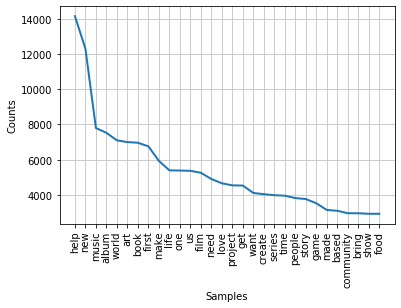

In [119]:
cfdist.plot(30,cumulative=False)

## Use Google News corpus to train word embeddings

In [89]:
import gensim
from gensim.models import KeyedVectors

In [90]:
# Load vectors directly from the file
filename = 'modeling/GoogleNews-vectors-negative300.bin.gz'
emb_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [91]:
#For word in list, get embedding, return all vectors"""
vectors = []
def get_vectors(list):
    for word in list: 
        try:
          vector = emb_model[word]
          vectors.append(vector)
        except KeyError: 
            pass
    return vectors

In [92]:
nodupes['vectors'] = nodupes["cleanblurb"].apply(get_vectors)

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
nodupes.head()

,table_id,robot_id,run_id,country,state,projecturls,data_id,d_name,d_blurb,d_goal,...,d_spotlight,location_id,loc_name,loc_state,category_id,cat_name,cat_slug,cleanblurb,stripblurb,vectors
0,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/184955320...,521645557,How to Breathe Underwater/In the Black Box -- ...,A surrealist's guide to navigating the dark de...,1500.0,...,True,2356940.0,Athens,GA,42,Pop,music/pop,"[a, surrealist, 's, guide, to, navigating, the...","[surrealist, guide, navigating, dark, descent,...","[[-0.072265625, -0.24316406, 0.22558594, 0.667..."
1,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/760226815...,504193797,Backpackable one-person high resolution UAV ma...,Continue to develop a user friendly one-person...,10000.0,...,False,2441116.0,Logan,UT,336,Flight,technology/flight,"[continue, to, develop, a, user, friendly, one...","[continue, develop, user, friendly, one, perso...","[[-0.072265625, -0.24316406, 0.22558594, 0.667..."
2,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/143006059...,1667139345,LOVE STORY,LOVE STORY IS ABOUT THE REAL LOVE THAT PEOPLE ...,2500.0,...,False,2503713.0,Tallahassee,FL,44,World Music,music/world music,"[love, story, is, about, the, real, love, that...","[love, story, real, love, people, dont, see, b...","[[-0.072265625, -0.24316406, 0.22558594, 0.667..."
3,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,failed,https://www.kickstarter.com/projects/533614462...,1389221860,Detroit Revue Concert,Together we can bring a star back on the map o...,35500.0,...,False,2391585.0,Detroit,MI,44,World Music,music/world music,"[together, we, can, bring, a, star, back, on, ...","[together, bring, star, back, map, motown, det...","[[-0.072265625, -0.24316406, 0.22558594, 0.667..."
4,Kickstarter,Kickstarter,Kickstarter_2019-07-18T03_20_05_009Z,US,successful,https://www.kickstarter.com/projects/131995875...,1730678034,"Let's Commit (to) a MURDER, SHE WROTE Album of...",Songwriter Joel B. New is creating his first-e...,6500.0,...,True,2459115.0,New York,NY,42,Pop,music/pop,"[songwriter, joel, b., new, is, creating, his,...","[songwriter, joel, b, new, creating, first, ev...","[[-0.072265625, -0.24316406, 0.22558594, 0.667..."


In [ ]:
# convert unix time to utc
# import datetime
# date = datetime.datetime.fromtimestamp(customTimestamp)
# print(date.strftime('%Y-%m-%d %H:%M:%S'))